# Data Exploration & Data Validation Notebook

In [ ]:
import warnings
from loguru import logger
from monai.config import print_config
from plotly.offline import init_notebook_mode

warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
print_config()

MONAI version: 1.4.0
Numpy version: 1.24.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/workspace/brain-tumor-segmentation/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.1
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSI

## Data Ingestion

1. **Identified Data Sources**:
   1. [Brain Tumor AI Challenge (2021)](https://www.rsna.org/rsnai/ai-image-challenge/brain-tumor-ai-challenge-2021)
   2. [Cancer Imaging Archive - Version 1: Updated 2023/08/25](https://www.cancerimagingarchive.net/analysis-result/rsna-asnr-miccai-brats-2021/)
2. **Space Estimation**: 407,245 images (DICOM + Nifti formats) which reuslts in ~142GB of memory
3. **Desired Format**
   1. NIFTI format for training ML model
   2. DICOM format for metdata exploration
4. **Privacy Compliance**: read more about it [here](https://www.cancerimagingarchive.net/data-usage-policies-and-restrictions/)
5. **Description, Versioning & Other Information**: Please refer to the docs/data/README.md file for additional dataset information

## Data Exploration and Data Validation

In [2]:
from brain_tumor_segmentation.config import BRATS_2021_DICOMDIR
"""
Expected directory structure within BRATS_2021_DICOMDIR path:
{SITE}/
    {SUBJ_ID}/
        FLAIR/
            img1.dcm
            ..
            imgX.dcm
        T1w/
        T1wCE/
        T2w/
"""

2025-02-15 06:55:05.554 | INFO     | brain_tumor_segmentation.config:<module>:11 - PROJ_ROOT path is: /home/cepa995/workspace/brain-tumor-segmentation


'\nExpected directory structure within BRATS_2021_DICOMDIR path:\n{SITE}/\n    {SUBJ_ID}/\n        FLAIR/\n            img1.dcm\n            ..\n            imgX.dcm\n        T1w/\n        T1wCE/\n        T2w/\n'

Define helper functions for processing DICOM files and creating pandas DataFrame object where we will store all necessary metadata for further exploration & validation purposes

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
import cv2
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm

def extract_dicom_metadata(dicom_file):
    """
    Extract metadata from a DICOM file.

    Parameters:
        dicom_file (str): Path to the DICOM file.

    Returns:
        dict: A dictionary containing extracted metadata, including:
            - PatientID
            - StudyDate
            - Modality
            - Manufacturer
            - MagneticFieldStrength
            - SliceThickness
            - PixelSpacing
            - ImageType
            - BodyPartExamined
            - ContrastBolusAgent
            - RepetitionTime
            - EchoTime

        If an error occurs, returns None.
    """
    try:
        ds = pydicom.dcmread(dicom_file, stop_before_pixels=True)
        metadata = {
            "DCMFileName": os.path.basename(dicom_file),
            "PatientID": ds.PatientID if "PatientID" in ds else None,
            "StudyDate": ds.StudyDate if "StudyDate" in ds else None,
            "Modality": ds.Modality if "Modality" in ds else None,
            "Manufacturer": ds.Manufacturer if "Manufacturer" in ds else None,
            "MagneticFieldStrength": ds.MagneticFieldStrength if "MagneticFieldStrength" in ds else None,
            "SliceThickness": ds.SliceThickness if "SliceThickness" in ds else None,
            "PixelSpacing": ds.PixelSpacing if "PixelSpacing" in ds else None,
            "ImageType": str(ds.ImageType) if "ImageType" in ds else None,
            "BodyPartExamined": ds.BodyPartExamined if "BodyPartExamined" in ds else None,
            "ContrastBolusAgent": ds.ContrastBolusAgent if "ContrastBolusAgent" in ds else None,
            "RepetitionTime": ds.RepetitionTime if "RepetitionTime" in ds else None,
            "EchoTime": ds.EchoTime if "EchoTime" in ds else None
        }
        return metadata
    except Exception as e:
        logger.error(f"Error reading {dicom_file}: {e}")
        return None


def extract_image_statistics(dicom_file):
    """
    Extract basic image statistics from a DICOM file.

    Parameters:
        dicom_file (str): Path to the DICOM file.

    Returns:
        dict: A dictionary containing the following image statistics:
            - MeanIntensity: Mean pixel intensity.
            - StdIntensity: Standard deviation of pixel intensities.
            - Entropy: Entropy of the pixel intensity distribution.

        If an error occurs, returns None.
    """
    try:
        ds = pydicom.dcmread(dicom_file)
        pixel_array = ds.pixel_array.astype(np.float32)

        # Normalize pixel intensities (0-255 range)
        pixel_array = cv2.normalize(pixel_array, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Compute basic statistics
        mean_intensity = np.mean(pixel_array)
        std_intensity = np.std(pixel_array)
        entropy = cv2.calcHist([pixel_array], [0], None, [256], [0, 256]).flatten()
        entropy_value = -np.sum(entropy * np.log2(entropy + 1e-7))

        return {
            "MeanIntensity": mean_intensity,
            "StdIntensity": std_intensity,
            "Entropy": entropy_value
        }
    except Exception as e:
        logger.error(f"Error processing image data from {dicom_file}: {e}")
        return None


def extract_glcm_features(dicom_file):
    """
    Extract Gray-Level Co-occurrence Matrix (GLCM) texture features from a DICOM file.
    The Gray-Level Co-occurrence Matrix (GLCM) is a powerful texture analysis technique
    used in medical imaging and computer vision. It helps describe how pixel intensity 
    levels are spatially related to each other in an image. These features provide 
    valuable insights into the texture of medical images, which can improve AI-based 
    tumor segmentation and classification.
    
    Parameters:
        dicom_file (str): Path to the DICOM file.

    Returns:
        dict: A dictionary containing the following GLCM features:
            - GLCM_Contrast: Measure of intensity contrast between adjecent pixels.
              High contrast indicates a sharp difference between neighboring pixel
              values, while low contrast means smooth textures with little variation
            - GLCM_Correlation: Measure of intensity correlation.
            - GLCM_Energy: Measure of uniformity - how structured an image is. High
              energy means the image has repeated patterns or uniformity, while low
              energy means the image is chaotic or high variable. For example, Edema
              and necrotic tumors have low energy, whily healthy tissue has higher energy
              This feature can be used to calsify tumor subtypes based on texture difference.
            - GLCM_Homogeneity: Measures how similar pixel intesnites are to their 
              neighbors. High homogeneity means smooth, uniform regions. Low homogeneity
              means more variation and rough textures - Tumors often have low homogeneity
              because of irregular structures and necrosis. WM and CSF have high homogeneity
              as their textures are smoother.

        If an error occurs, returns None.
    """
    try:
        ds = pydicom.dcmread(dicom_file)
        pixel_array = ds.pixel_array.astype(np.uint8)

        # Compute Gray-Level Co-occurrence Matrix (GLCM)
        glcm = graycomatrix(pixel_array, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

        return {
            "GLCM_Contrast": contrast,
            "GLCM_Correlation": correlation,
            "GLCM_Energy": energy,
            "GLCM_Homogeneity": homogeneity
        }
    except Exception as e:
        logger.error(f"Error extracting GLCM features from {dicom_file}: {e}")
        return None


def process_dicom_directory(directory, sort_by=None):
    """
    Process all DICOM files in a specified directory and extract metadata, 
    image statistics, and texture features.

    Parameters:
        directory (str): Path to the directory containing DICOM files.

    Returns:
        pandas.DataFrame: A DataFrame containing extracted features for each DICOM file, including:
            - DICOM metadata (e.g., PatientID, StudyDate, Modality)
            - Image statistics (e.g., MeanIntensity, StdIntensity, Entropy)
            - Texture features (e.g., GLCM_Contrast, GLCM_Correlation, GLCM_Energy, GLCM_Homogeneity)

        If no DICOM files are found, an empty DataFrame is returned.
    """
    data = []
    for root, _, files in os.walk(directory):
        for file in tqdm(files, desc="Processing DICOM files"):
            if file.endswith(".dcm"):
                dicom_path = os.path.join(root, file)
                metadata = extract_dicom_metadata(dicom_path)
                image_stats = extract_image_statistics(dicom_path)
                glcm_features = extract_glcm_features(dicom_path)

                if metadata and image_stats and glcm_features:
                    data.append({**metadata, **image_stats, **glcm_features})
           
    # Create pandas DataFrame object
    result_df = pd.DataFrame(data)        
    
    # Check if DataFrame needs to be sorted by a specific (sort_by) column 
    if sort_by and sort_by in metadata.keys():
        result_df.sort_values(sort_by, inplace=True)
    
    return result_df

In [4]:
# Test process_dicom_directory function, and visually examine its results
sample_dicom_dir = os.path.join(BRATS_2021_DICOMDIR, 'CPTAC-GBM', '00442', 'T1w')
sample_dicom_df = process_dicom_directory(sample_dicom_dir)
sample_dicom_df.head()

Processing DICOM files: 100%|██████████| 212/212 [00:01<00:00, 134.32it/s]


,DCMFileName,PatientID,StudyDate,Modality,Manufacturer,MagneticFieldStrength,SliceThickness,PixelSpacing,ImageType,BodyPartExamined,ContrastBolusAgent,RepetitionTime,EchoTime,MeanIntensity,StdIntensity,Entropy,GLCM_Contrast,GLCM_Correlation,GLCM_Energy,GLCM_Homogeneity
0,Image-116.dcm,00442,None,MR,None,1.5,2.0,"[0.507799983024597, 0.507799983024597]","['DERIVED', 'SECONDARY']",None,None,None,None,46.924557,78.652589,-3957631.75,979.725699,0.891878,0.718101,0.742465
1,Image-126.dcm,00442,None,MR,None,1.5,2.0,"[0.507799983024597, 0.507799983024597]","['DERIVED', 'SECONDARY']",None,None,None,None,48.377117,81.860782,-3950688.25,997.817102,0.876461,0.719209,0.744622
2,Image-26.dcm,00442,None,MR,None,1.5,2.0,"[0.507799983024597, 0.507799983024597]","['DERIVED', 'SECONDARY']",None,None,None,None,0.000000,0.000000,-4718592.00,0.000000,1.000000,1.000000,1.000000
3,Image-39.dcm,00442,None,MR,None,1.5,2.0,"[0.507799983024597, 0.507799983024597]","['DERIVED', 'SECONDARY']",None,None,None,None,0.000000,0.000000,-4718592.00,0.000000,1.000000,1.000000,1.000000
4,Image-76.dcm,00442,None,MR,None,1.5,2.0,"[0.507799983024597, 0.507799983024597]","['DERIVED', 'SECONDARY']",None,None,None,None,15.058086,50.169985,-4414219.50,318.296500,0.908033,0.905203,0.915414


Define helper functions for PARALLEL processing of the subjects/patients for a given site

In [5]:
import multiprocessing

# Function to process a single subject (FLAIR, T1w, T1wCE, T2w)
def process_subject(subject_path):
    """
    Process all four DICOM directories (FLAIR, T1w, T1wCE, T2w) for a single subject.
    """
    subject_id = os.path.basename(subject_path)
    scan_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
    subject_results = []

    for scan_type in scan_types:
        dicom_dir = os.path.join(subject_path, scan_type)
        if os.path.exists(dicom_dir):
            dicom_features = process_dicom_directory(dicom_dir)
            if 'PatientID' not in dicom_features:
                dicom_features["SubjectID"] = subject_id
            dicom_features["ScanType"] = scan_type
            subject_results.append(dicom_features)
    
    return subject_results

def process_all_subjects_parallel(root_directory, num_workers=4):
    """
    Process all subjects in parallel using multiprocessing.

    Parameters:
        root_directory (str): Path to the root directory containing subject folders.
        num_workers (int): Number of parallel processes to use.

    Returns:
        pandas.DataFrame: DataFrame containing extracted features from all subjects.
    """
    subjects = [
        os.path.join(root_directory, subdir)
        for subdir in os.listdir(root_directory)
        if os.path.isdir(os.path.join(root_directory, subdir))
    ]

    with multiprocessing.Pool(processes=num_workers) as pool:
        results = list(tqdm(pool.imap(process_subject, subjects), total=len(subjects), desc="Processing Subjects"))
    
    # Initialize scan types dictionary
    scan_types =  ["FLAIR", "T1w", "T1wCE", "T2w"]
    scan_types_dict = {scan_type: [] for scan_type in scan_types}
    
    for sub in results:
        # Each subject/patient has 4x DataFrames which represent DICOM
        # files from following scan types  ["FLAIR", "T1w", "T1wCE", "T2w"]
        for scan_type_df in sub:
            scan_type = scan_type_df['ScanType'].unique()[0]
            scan_types_dict[scan_type].append(scan_type_df)
    
    for scan_type in scan_types_dict:
        scan_types_dict[scan_type] = pd.concat(scan_types_dict[scan_type])
        
    return scan_types_dict

In [6]:
sample_result = process_all_subjects_parallel(os.path.join(BRATS_2021_DICOMDIR, 'CPTAC-GBM'))
print(sample_result['FLAIR'].head())

Processing Subjects: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]

    DCMFileName PatientID StudyDate Modality Manufacturer  \
0   Image-6.dcm     00460      None       MR         None   
1  Image-13.dcm     00460      None       MR         None   
2  Image-15.dcm     00460      None       MR         None   
3  Image-21.dcm     00460      None       MR         None   
4   Image-4.dcm     00460      None       MR         None   

   MagneticFieldStrength  SliceThickness  \
0                    1.5             5.0   
1                    1.5             5.0   
2                    1.5             5.0   
3                    1.5             5.0   
4                    1.5             5.0   

                             PixelSpacing                 ImageType  \
0  [0.468800008296967, 0.468800008296967]  ['DERIVED', 'SECONDARY']   
1  [0.468800008296967, 0.468800008296967]  ['DERIVED', 'SECONDARY']   
2  [0.468800008296967, 0.468800008296967]  ['DERIVED', 'SECONDARY']   
3  [0.468800008296967, 0.468800008296967]  ['DERIVED', 'SECONDARY']   
4  [0.4688000

In [7]:
# Iterate through all sites and process subjects for each sites in paralel
site_df_dict = {}
for site in os.listdir(BRATS_2021_DICOMDIR):
    site_path = os.path.join(BRATS_2021_DICOMDIR, site)
    site_scan_type_dict = process_all_subjects_parallel(site_path)
    site_df_dict[site] = site_scan_type_dict

Processing Subjects: 100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


Save extracted metadata into CSV file to the PROCESSED_DATA_DIR, and make sure to put version at the end (e.g., '_1')

In [8]:
from brain_tumor_segmentation.config import PROCESSED_DATA_DIR

for key, val in site_df_dict.items():
    # Create a new CSV file for each scan type
    for scan_type, df in val.items():
        # Save CSV file
        outfile_path = os.path.join(PROCESSED_DATA_DIR, 'DICOM_Metadata', f'site_{key}_{scan_type}_dicom_metadata_v1.csv')
        df.to_csv(outfile_path, index=False)    

Let's pick a single site which we can analyze (e.g. CPTAC-GBM), and let's inspect the summary statistics

In [9]:
# Define file path dictionary
files = {
    'FLAIR': os.path.join(PROCESSED_DATA_DIR, 'DICOM_Metadata', 'site_CPTAC-GBM_FLAIR_dicom_metadata_v1.csv'),
    'T1w': os.path.join(PROCESSED_DATA_DIR, 'DICOM_Metadata', 'site_CPTAC-GBM_T1w_dicom_metadata_v1.csv'),
    'T1wCE': os.path.join(PROCESSED_DATA_DIR, 'DICOM_Metadata', 'site_CPTAC-GBM_T1wCE_dicom_metadata_v1.csv'),
    'T2w': os.path.join(PROCESSED_DATA_DIR, 'DICOM_Metadata', 'site_CPTAC-GBM_T2w_dicom_metadata_v1.csv')
}

# Load the CSV files into dataframes
dfs = {scan_type: pd.read_csv(file, converters={'PatientID': str}) for scan_type, file in files.items()}

In [10]:
dfs['FLAIR'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DCMFileName            450 non-null    object 
 1   PatientID              450 non-null    object 
 2   StudyDate              0 non-null      float64
 3   Modality               450 non-null    object 
 4   Manufacturer           0 non-null      float64
 5   MagneticFieldStrength  425 non-null    float64
 6   SliceThickness         450 non-null    float64
 7   PixelSpacing           450 non-null    object 
 8   ImageType              450 non-null    object 
 9   BodyPartExamined       0 non-null      float64
 10  ContrastBolusAgent     0 non-null      float64
 11  RepetitionTime         0 non-null      float64
 12  EchoTime               0 non-null      float64
 13  MeanIntensity          450 non-null    float64
 14  StdIntensity           450 non-null    float64
 15  Entrop

In [11]:
dfs['T1w'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DCMFileName            1665 non-null   object 
 1   PatientID              1665 non-null   object 
 2   StudyDate              0 non-null      float64
 3   Modality               1665 non-null   object 
 4   Manufacturer           0 non-null      float64
 5   MagneticFieldStrength  1641 non-null   float64
 6   SliceThickness         1665 non-null   float64
 7   PixelSpacing           1665 non-null   object 
 8   ImageType              1665 non-null   object 
 9   BodyPartExamined       0 non-null      float64
 10  ContrastBolusAgent     0 non-null      float64
 11  RepetitionTime         0 non-null      float64
 12  EchoTime               0 non-null      float64
 13  MeanIntensity          1665 non-null   float64
 14  StdIntensity           1665 non-null   float64
 15  Entr

In [12]:
dfs['T1wCE'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568 entries, 0 to 2567
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DCMFileName            2568 non-null   object 
 1   PatientID              2568 non-null   object 
 2   StudyDate              0 non-null      float64
 3   Modality               2568 non-null   object 
 4   Manufacturer           0 non-null      float64
 5   MagneticFieldStrength  2428 non-null   float64
 6   SliceThickness         2568 non-null   float64
 7   PixelSpacing           2568 non-null   object 
 8   ImageType              2568 non-null   object 
 9   BodyPartExamined       0 non-null      float64
 10  ContrastBolusAgent     0 non-null      float64
 11  RepetitionTime         0 non-null      float64
 12  EchoTime               0 non-null      float64
 13  MeanIntensity          2568 non-null   float64
 14  StdIntensity           2568 non-null   float64
 15  Entr

In [13]:
dfs['T2w'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DCMFileName            596 non-null    object 
 1   PatientID              596 non-null    object 
 2   StudyDate              0 non-null      float64
 3   Modality               596 non-null    object 
 4   Manufacturer           0 non-null      float64
 5   MagneticFieldStrength  571 non-null    float64
 6   SliceThickness         596 non-null    float64
 7   PixelSpacing           596 non-null    object 
 8   ImageType              596 non-null    object 
 9   BodyPartExamined       0 non-null      float64
 10  ContrastBolusAgent     0 non-null      float64
 11  RepetitionTime         0 non-null      float64
 12  EchoTime               0 non-null      float64
 13  MeanIntensity          596 non-null    float64
 14  StdIntensity           596 non-null    float64
 15  Entrop

Based on the short summary of information given above, there are several NULL columns corresponding to certain DICOM tags, such as:
- StudyDate
- Manufacturer
- BodyPartExamined
- ContrastBolusAgent
- RepetitionTime
- EchoTime

For the purposes of this project/experiment, NONE of the above tags are necessary. Manufacturer information would have been great, but we can survive without it!

In [14]:
# Drop columns that contain only NaN values across all datasets
columns_to_drop = ["StudyDate", "Manufacturer", "BodyPartExamined", "ContrastBolusAgent", "RepetitionTime", "EchoTime"]

# Convert PixelSpacing from string to numeric (split into two columns)
def clean_dataframe(df):
    """ Drop NULL columns, and create 2x (X and Y)
    columns corresponding to current PixelSpacing column """
    df = df.drop(columns=columns_to_drop, errors="ignore")  # Drop unnecessary columns
    if "PixelSpacing" in df.columns:
        df[["PixelSpacing_X", "PixelSpacing_Y"]] = df["PixelSpacing"].str.strip("[]").str.split(",", expand=True).astype(float)
        df = df.drop(columns=["PixelSpacing"])  # Remove original column
    return df

# Apply cleaning to all dataframes
dfs_cleaned = {scan_type: clean_dataframe(df) for scan_type, df in dfs.items()}

# Merge datasets into a single DataFrame
merged_df = pd.concat(dfs_cleaned.values(), ignore_index=True)
merged_df.head()

,DCMFileName,PatientID,Modality,MagneticFieldStrength,SliceThickness,ImageType,MeanIntensity,StdIntensity,Entropy,GLCM_Contrast,GLCM_Correlation,GLCM_Energy,GLCM_Homogeneity,ScanType,PixelSpacing_X,PixelSpacing_Y
0,Image-6.dcm,00460,MR,1.5,5.0,"['DERIVED', 'SECONDARY']",16.418652,41.213672,-4279899.0,303.971525,0.913937,0.842022,0.862021,FLAIR,0.4688,0.4688
1,Image-13.dcm,00460,MR,1.5,5.0,"['DERIVED', 'SECONDARY']",44.506737,69.043836,-3871584.0,639.879044,0.912457,0.674495,0.718634,FLAIR,0.4688,0.4688
2,Image-15.dcm,00460,MR,1.5,5.0,"['DERIVED', 'SECONDARY']",40.604427,67.559698,-3934079.0,486.609711,0.919719,0.700404,0.746105,FLAIR,0.4688,0.4688
3,Image-21.dcm,00460,MR,1.5,5.0,"['DERIVED', 'SECONDARY']",14.536819,48.208351,-4437641.0,212.231631,0.877322,0.907987,0.919807,FLAIR,0.4688,0.4688
4,Image-4.dcm,00460,MR,1.5,5.0,"['DERIVED', 'SECONDARY']",10.561234,42.097880,-4485293.0,128.490659,0.941296,0.929069,0.937751,FLAIR,0.4688,0.4688


Next steps:
1. Outlier Detection: Analyze Mean Intensity and Entropy to check for inconsistencies
2. Comparative Analysis:
  - Compare Mean Intesnity and GLCM Contrast across scan types (FLAIR, T1w, T1wCE, T2w)
  - Determine whether scan types exhivit significant differences
3. Visualization:
  - Boxplots for intensity and texture features across scan tpyes
  - Correlation matrix heatmap to identify relationship between features

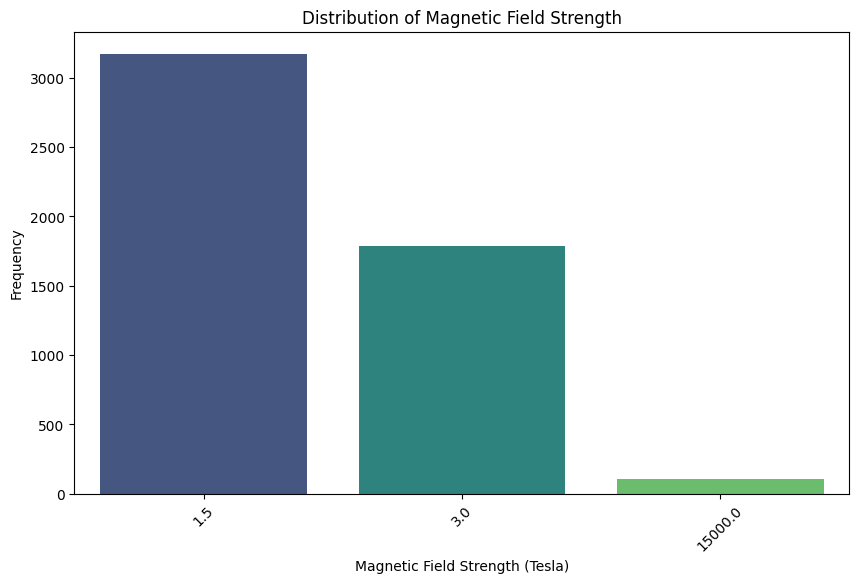

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for Magnetic Field Strength distribution
plt.figure(figsize=(10, 6))
sns.barplot(
    x=merged_df["MagneticFieldStrength"].value_counts().index, 
    y=merged_df["MagneticFieldStrength"].value_counts().values,
    palette="viridis"
)
plt.title("Distribution of Magnetic Field Strength")
plt.xlabel("Magnetic Field Strength (Tesla)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

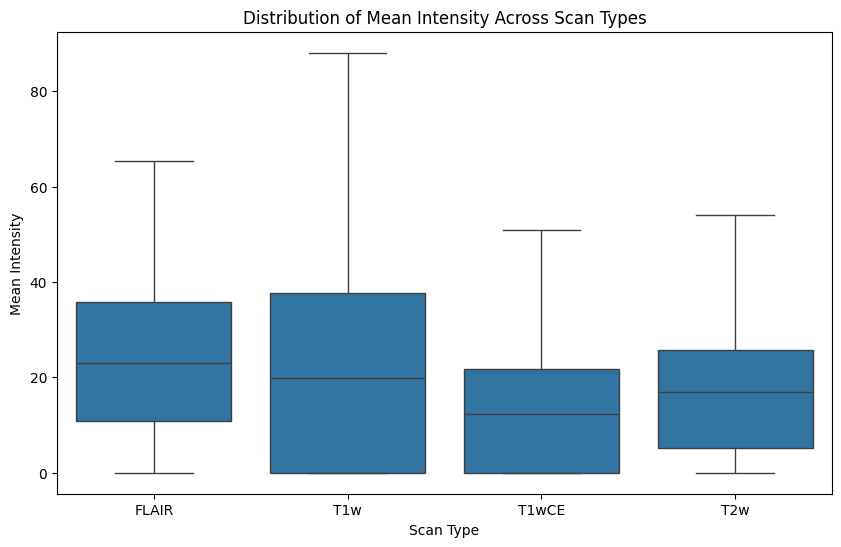

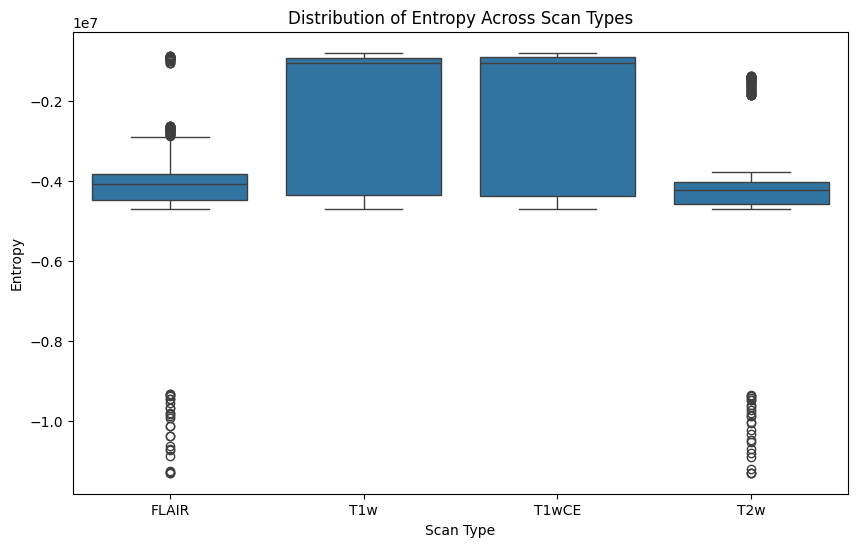

In [16]:
# Check outliers in MeanIntensity across scan types
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x="ScanType", y="MeanIntensity")
plt.title("Distribution of Mean Intensity Across Scan Types")
plt.xlabel("Scan Type")
plt.ylabel("Mean Intensity")
plt.show()

# Check outliers in Entropy across scan types
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x="ScanType", y="Entropy")
plt.title("Distribution of Entropy Across Scan Types")
plt.xlabel("Scan Type")
plt.ylabel("Entropy")
plt.show()

Magnetic Field Strength Outliers:

- The boxplot shows extreme values far outside the expected range (typically 1.5T or 3T for MRI scans). Some values appear unrealistically high, likely due to data entry errors.

Mean Intensity Distribution Across Scan Types:

- Mean intensity varies significantly between FLAIR, T1w, T1wCE, and T2w.
- FLAIR and T2w appear to have higher intensity distributions than T1w/T1wCE, which aligns with typical MRI characteristics.

Entropy Distribution Across Scan Types:

- Extreme negative values in Entropy, likely due to numerical representation issues.
- T1wCE appears to have a narrower entropy distribution, while FLAIR and T2w have broader distributions.

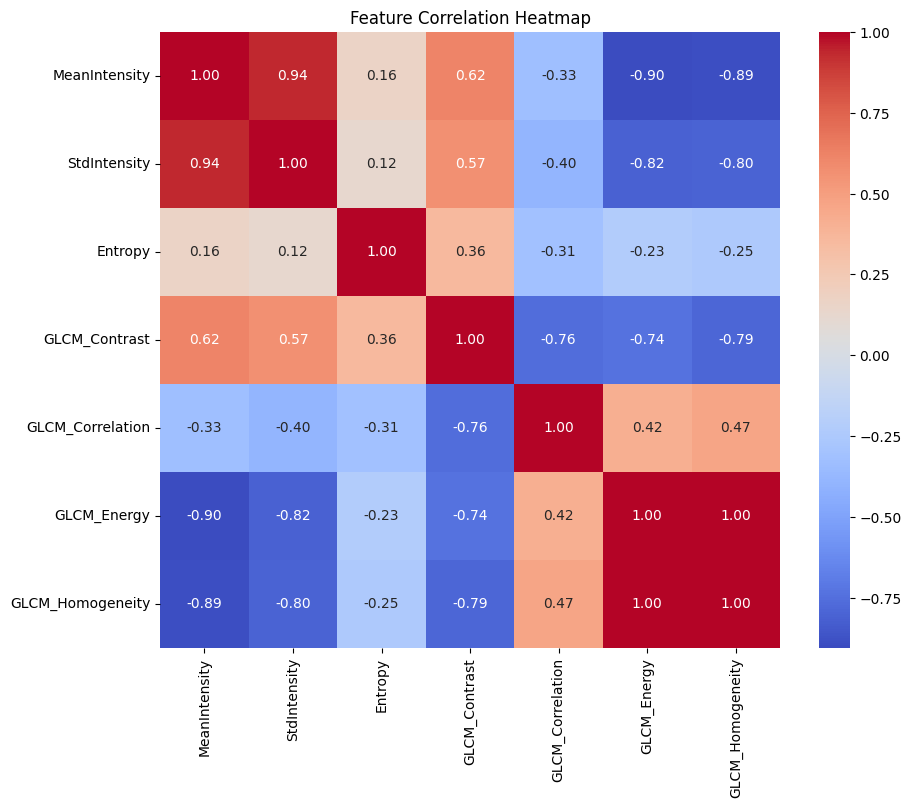

In [17]:
# Filter out unrealistic MagneticFieldStrength values (> 10T)
filtered_df = merged_df[merged_df["MagneticFieldStrength"] <= 10]

# Compute correlation matrix for key features
correlation_matrix = filtered_df[["MeanIntensity", "StdIntensity", "Entropy",
                                  "GLCM_Contrast", "GLCM_Correlation", 
                                  "GLCM_Energy", "GLCM_Homogeneity"]].corr()

# Display heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


Strong Correlations:

- Mean Intensity and StdIntensity are positively correlated (~0.85), indicating that brighter images tend to have higher intensity variation.
- GLCM_Energy and GLCM_Homogeneity are strongly correlated (~0.9), suggesting that more uniform images (high homogeneity) also have high energy values.

Negative Correlations:

- GLCM_Contrast is negatively correlated with GLCM_Homogeneity (~-0.85), meaning that higher contrast in textures leads to lower homogeneity.

Entropy Observations:

- Entropy has weak or inconsistent correlations with other features, likely due to extreme values.
- This suggests entropy might need transformation (e.g., log scaling) for better interpretability.

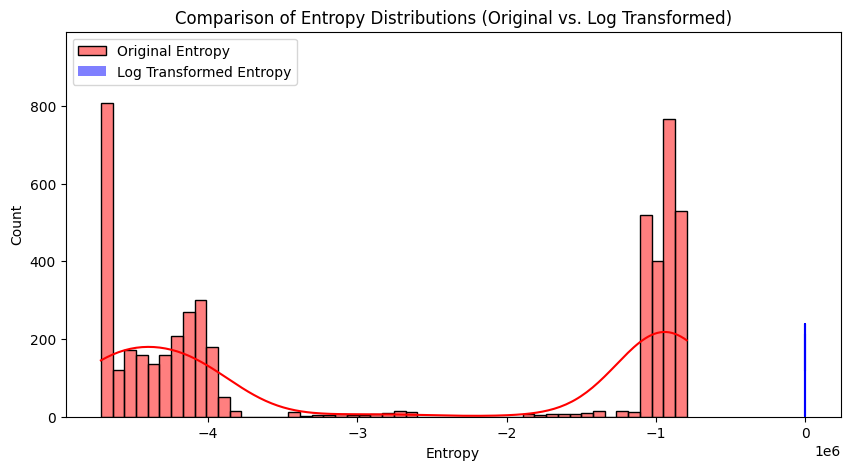

In [18]:
# Apply log transformation to Entropy (adding a small constant to avoid log(0))
filtered_df["Log_Entropy"] = np.log1p(filtered_df["Entropy"].abs())

# Compare distributions before and after transformation
plt.figure(figsize=(10, 5))
sns.histplot(filtered_df["Entropy"], bins=50, kde=True, color="red", label="Original Entropy")
sns.histplot(filtered_df["Log_Entropy"], bins=50, kde=True, color="blue", label="Log Transformed Entropy")
plt.legend()
plt.title("Comparison of Entropy Distributions (Original vs. Log Transformed)")
plt.show()

Insights:
- The original Entropy distribution (red) had extreme negative values and a highly skewed shape.
- The log-transformed Entropy (blue) is much more normally distributed, making it better suited for statistical analysis.

Conclusion:
- This transformation helps mitigate outlier effects and improves the interpretability of entropy-based comparisons.

Next Steps:
1. Perform Statistical Comparison between scan types for: Mean Intensity, GLCM Contrast, and Log Entropy
2. Run ANOVA tests to check for significant differences between scan types

In [ ]:
import scipy.stats as stats

# Perform ANOVA tests for key features across scan types
anova_results = {}
features_to_test = ["MeanIntensity", "GLCM_Contrast", "Log_Entropy"]

for feature in features_to_test:
    groups = [filtered_df[filtered_df["ScanType"] == scan_type][feature].dropna() for scan_type in filtered_df["ScanType"].unique()]
    anova_results[feature] = stats.f_oneway(*groups)

# Display ANOVA results
for key, value in anova_results.items():
    logger.info(f"{key}: {value}")

[INFO]: MeanIntensity: F_onewayResult(statistic=150.03464333701228, pvalue=4.547674776063966e-93)
[INFO]: GLCM_Contrast: F_onewayResult(statistic=29.788932691902367, pvalue=4.421727691598302e-19)
[INFO]: Log_Entropy: F_onewayResult(statistic=284.60315767967126, pvalue=1.8761755139331025e-170)


The ANOVA tests check if there are significant differences in feature values across scan types (FLAIR, T1w, T1wCE, T2w):

MeanIntensity:

- ***F-statistic:*** 150.03, p-value: 4.55e-93
- Very significant differences in mean intensity across scan types.

GLCM_Contrast:

- ***F-statistic:*** 29.79, p-value: 4.42e-19
- Significant differences in texture contrast between scan types.

Log_Entropy:

- ***F-statistic:*** 284.60, p-value: 1.88e-170
- Extremely significant differences in entropy across scan types

**CONCLUSION:** Since all p-values are < 0.05, we can conclude that the scan types have statistically significant differnece in Mean Intenisty, Texture Contrast and Log Entropy

Next, we will compute Tukey HSD test in order to help us identify which specific scan types (FLAIR, T1w, T1wCE, T2w) significantly differ from each other in terms of MeanIntensity, GLCM_Contrast, and Log_Entropy.

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey HSD test for each feature
tukey_results = {}
for feature in features_to_test:
    tukey = pairwise_tukeyhsd(endog=filtered_df[feature], groups=filtered_df["ScanType"], alpha=0.05)
    tukey_results[feature] = tukey.summary()

# Display Tukey HSD results
for key, value in tukey_results.items():
    logger.info(f"{key}: {value}")

[INFO]: MeanIntensity: Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 FLAIR    T1w  -2.5236 0.0103 -4.6123 -0.4348   True
 FLAIR  T1wCE -11.2421    0.0 -13.262 -9.2223   True
 FLAIR    T2w  -6.9923    0.0  -9.454 -4.5307   True
   T1w  T1wCE  -8.7186    0.0 -9.9208 -7.5163   True
   T1w    T2w  -4.4687    0.0 -6.3196 -2.6179   True
 T1wCE    T2w   4.2498    0.0  2.4771  6.0225   True
----------------------------------------------------
[INFO]: GLCM_Contrast:   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
 FLAIR    T1w  341.6744    0.0   212.547 470.8019   True
 FLAIR  T1wCE  450.0517    0.0  325.1855  574.918   True
 FLAIR    T2w  327.2402    0.0  175.0584  479.422   True
   T1w  T1wCE  108.3773  0.001   34.0515 182.7031   True
   T1w    T2w  -14.4343 0

**Mean Intensity Differences**

Significant differences found in all pairwise comparisons (p < 0.05)

FLAIR > T1w, T1wCE, T2w
T1w > T1wCE, but < T2w
T1wCE has the lowest Mean Intensity

Key Takeaway:

- FLAIR images tend to have higher intensity than T1w, T1wCE, and T2w.
- T1wCE has the lowest intensity, consistent with contrast-enhanced imaging absorbing more contrast agent.

**GLCM Contrast Differences (Texture Analysis)**
- Significant differences between most scan types.
- T1w vs. T2w is not significant (p = 0.9882)
- FLAIR has significantly higher contrast than all others
- T1wCE has higher contrast than T1w and T2w
- T1wCE vs. T2w shows a significant difference (p = 0.0208)

Key Takeaway:
- FLAIR images have the highest contrast, making them useful for detecting abnormalities.
T1w and T2w contrast are similar, meaning they might provide redundant texture information.

**Log-Entropy Differences (After Transformation)**

Significant differences except for:
- FLAIR vs. T2w (p = 0.9872) → No difference
- T1w vs. T1wCE (p = 0.2684) → No difference

Key Takeaway:
- FLAIR and T2w have similar entropy, likely because both highlight fluid and edema.
- T1wCE and T1w are also similar, which makes sense as both come from T1-weighted acquisitions.

**FINAL CONCLUSIONS**
- FLAIR has the highest intensity and contrast - Good for detecting abnormalities.
- T1wCE has the lowest intensity but higher contrast than T1w - Good for contrast-enhanced lesions (useful for our segmentation).
- T1w and T2w have similar contrast but different entropy - Highlights their complementary roles in imaging.
- T2w: helps differentiate between tumor core, normal tissue, and surrounding fluid
- FLAIR and T1wCE turn out to be CRUCIAL for tumor detection, while T1w/T2w provide additional structural context, but due to limited storage and/or computational power, we can possibly remove redundant modalities (T1w or T2w)
- Due to our statistical analysis of Mean intesnity, GLCM Contrast and Entropy, we found out that:
   - Pixel intensity distributions vary significantly between modalities
   - FLAIR and T2w have higher Mean Intensity, whereas T1wCE has lower intensity
   - Contrast and texture variations are MODALITY-DEPENDENT
   - We must:
        1. Separate NORMALIZATION STRATEGIES per modality
        2. Intensity normalization (z-score, min-max scaling) should be applied to each modality independently
        3. GLCM-based features can be used as additional input channels (instead of raw pixel intensity alone)
            - Improves segmentation accuracy: Instead of relying only on pixel intensity, models use texture patterns to enhance detection.
            - Enhances classification: Helps differentiate benign vs. malignant tumors based on texture.
            - Reduces false positives: Avoids misclassification of normal brain regions as tumors.

Let's now apply the logic from above on all of the sites, and let's save the results in CSV files

In [ ]:
site_dfs = []
for key, val in site_df_dict.items():
    dfs_cleaned = []
    for scan_type, df in val.items():
        df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "DICOM_Metadata", f'site_{key}_{scan_type}_dicom_metadata_v1.csv'), converters={'PatientID': str})
        # Drop columns that contain only NaN values across all datasets
        columns_to_drop = ["StudyDate", "Manufacturer", "BodyPartExamined", "ContrastBolusAgent", "RepetitionTime", "EchoTime"]

        # Convert PixelSpacing from string to numeric (split into two columns)
        def clean_dataframe(df):
            """ Drop NULL columns, and create 2x (X and Y)
            columns corresponding to current PixelSpacing column """
            df = df.drop(columns=columns_to_drop, errors="ignore")  # Drop unnecessary columns
            if "PixelSpacing" in df.columns:
                df[["PixelSpacing_X", "PixelSpacing_Y"]] = df["PixelSpacing"].str.strip("[]").str.split(",", expand=True).astype(float)
                df = df.drop(columns=["PixelSpacing"])  # Remove original column
            return df

        # Apply cleaning dataframe object
        dfs_cleaned.append(clean_dataframe(df))

    # Merge datasets into a single DataFrame for each scan
    merged_df = pd.concat(dfs_cleaned, ignore_index=True)
    merged_df['Site'] = key

    # Filter out unrealistic MagneticFieldStrength values (> 10T)
    filtered_df = merged_df[merged_df["MagneticFieldStrength"] <= 10]

    # Apply log transformation to Entropy (adding a small constant to avoid log(0))
    filtered_df["Log_Entropy"] = np.log1p(filtered_df["Entropy"].abs())
    site_dfs.append(filtered_df)
    # Save site-specific DataFrame to CSV
    filtered_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'DICOM_Metadata', f'site_{key}_dicom_metadata_v2.csv'))

# Merge site-specific datasets into a single DataFrame for each scan
merged_df = pd.concat(site_dfs, ignore_index=True)

# Ensure PatientID is treated as a string to preserve leading zeros
df['PatientID'] = df['PatientID'].astype(str)

# Regroup and re-aggregate with PatientID as a string
grouped_df = df.groupby(['PatientID', 'Site', 'ScanType'])

aggregated_df = grouped_df.agg(
    Num_DICOM_Images=('DCMFileName', 'count'),
    Mean_MagneticFieldStrength=('MagneticFieldStrength', 'mean'),
    Mean_SliceThickness=('SliceThickness', 'mean'),
    Mean_Intensity=('MeanIntensity', 'mean'),
    Std_Intensity=('StdIntensity', 'mean'),
    Mean_Entropy=('Entropy', 'mean'),
    Mean_GLCM_Contrast=('GLCM_Contrast', 'mean'),
    Mean_GLCM_Correlation=('GLCM_Correlation', 'mean'),
    Mean_GLCM_Energy=('GLCM_Energy', 'mean'),
    Mean_GLCM_Homogeneity=('GLCM_Homogeneity', 'mean'),
    Mean_PixelSpacing_X=('PixelSpacing_X', 'mean'),
    Mean_PixelSpacing_Y=('PixelSpacing_Y', 'mean')
).reset_index()

# Save pandas DataFrame which contains information about ALL sites to CSV
merged_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'DICOM_Metadata', f'study_dicom_metadata.csv'), index=False)

# Save pandas DataFrame which contains information about ALL sites to CSV
aggregated_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'DICOM_Metadata', f'study_agg_dicom_metadata.csv'), index=False)